<h2> Training Deep Neural Networks </h2> 

To tackle complex problems, we need to train much deeper DNN with 10 layers or much more, each containing hundreds of neurons. 

<h3> Issues faced when training DNN </h3> 

- Vanishing gradient/ exploding gradients
- Not enough training data for a large network
- Training will be extemely slow
- A model with millions of parameters would risk overfitting the training set if there is not enough instances. 

<h3> Vanishing/Exploding Gradients Problems </h3> 

- The backpropagation algorithm works by going from the output layer to the input layer, propagating the error gradient on the way. 
- Once the gradient for each parameter is calculated, the gradients are used to update each parameter. 
- **However** gradients get smaller and smaller as the algorithm progresses to the lower layers. 

- Due to this vanishing gradient, the weights and biases of the lower layers stay unchanged. 


**The opposite can happen too**

- In some cases, the gradient gets bigger when moving to lower layers, hence the lower layers end up getting large weight updates and the algorithm diverges. 


In a general sense, deep neural networks suffer from unstable gradients throughout the network resulting in different layers learning at different speeds. 

Issues which contribute to this:

- Combination of logistic sigmoid activation function and the weight initialization technique (Random initialization using a normal distribution with a mean of 0 and a standard dev. of 1)

- Looking at the sigmoid activation function, it saturates at large positive and negative inputs and the function saturates at 0 and 1. At these saturated positions, the gradient is close to zero and hence cannot back propagate through a network. Hence there is not enough to be backpropagated to lower layers.


<h3> Vanishing gradient can occur in multiple ways </h3> 

Either you can have your gradient decreasing as you reach lower layers during backpropagation as you are running out of gradient, or your outputs from the neuron are always zero causing no gradient to exist (Usually happens when your weights are giving out zeros as the output for neuron)


<h3> Glorot and He Initialization </h3> 

For signals to flow properly during forward pass and back propagation, it is required that the variance of the input be the same as the variance of the output. 

It is not possible to guarantee this condition, unless the layer has an equal number of inputs and neurons. Instead a valid compromise is to **randomly initialize the connection weights of each layer as follows**:

fan(avg) = (fan(in) + fan(out))/2

Different strategies exist, however they differ only by the scale of variance and whether they use fan(avg) or fan(in)

For all the different initialization strategies, we need to plug in the appropriate variance equation which is dependent on **fan(avg) or fan(in)**. Then we can get the boundary of initialization and find the initialized weights and biases using uniform distribution. 

By default Keras uses Glorot initialization where we use 1/fan(avg) as the variance to plug into find the boundaries for uniform distribution. 


<h3> Nonsaturating Activation Functions </h3> 

<h4> Dying ReLU </h4>

Dying ReLU are neurons which are outputing 0s continuously. This happens when all the weights of your network(or weights for most neurons) are tweaked such that every output is a negative, causing the ReLU output to be a zero always. 

A variant of the ReLU function is the Leaky ReLU function. 

In Leaky ReLU, instead of max(0,z), we have max(a * z, z) in which **a** is the hyperparameter which defines how much the function leaks. It is the slope of the function below z = 0 and usually set to 0.01. 


<h4> Exponential Linear Unit </h4> 

In this activation function, if z > 0, then the output is z. However if z < 0, output is a(exp(z) - 1). For all values below 0, it takes on a negative value, has a nonzero gradient which avoids dead neuron problem, and closer to zero, the function is smooth, hence it doesnt bounce around during convergence and fuaster in training than the ReLU. But it is slower in prediction as the function is more complicated.

<h4> Standardized Exponential Linear Unit </h4> 

This activation function allows the network to self normalize where the weights are with standard dev of 1 and mean 0. But the following conditions are required for that to happen:

- Input features must be Standardized (mean 0 and standard dev of 1).
- Every hidden layers weight must be initialized under the **LeCunn Normal Initialization**
- Sequential API needs to be used or else normalization is not guaranteed. 


Effectiveness of activation functions:

SELU>ELU>LeakReLU(and variants)>ReLU>tanh>sigmoid

<h2> Batch Normalization(BN) </h2> 

Using the ELU or LeakyReLU and its variants, we reduce the problem of vanishing/exploding gradients as we ensure that neurons wont die and that weights and biases are in a range which prevents explosion. But it doesnt guarantee that it wont come back during training. 

Involves adding an operation in the model before or after the activation function of each layer, to zero center and normalize each input. Then scaling and shifting the result using 2 new parameter vectors per layer. 

Essentially for each batch, you normalize each feature to have mean 0 and sd 1. Then you do element-wise multiplication with gamma vector in which gamma is a scaling factor applied for each feature of each input. Then you shift it with a vector beta, which also is available for the entire vector. 

<h2> Implementing Batch Normalization </h2> 


In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full),(X_test, y_test) = fashion_mnist.load_data()

In [3]:
X_valid,X_train = X_train_full[:5000]/255.0,X_train_full[5000:]/255.0
y_valid,y_train = y_train_full[:5000], y_train_full[5000:]

In [6]:
model_bn = keras.models.Sequential()
model_bn.add(keras.layers.Flatten(input_shape = [28,28]))
#add batch normalization layer
model_bn.add(keras.layers.BatchNormalization())
model_bn.add(keras.layers.Dense(300,activation = "elu",kernel_initializer = "he_normal"))
#above initializer can also be made as follows:
#he_normal_init = keras.initializers.VarianceScaling(scale = 2, mode = "fan_in", distribution = "normal")
model_bn.add(keras.layers.BatchNormalization())
model_bn.add(keras.layers.Dense(100,activation = "elu",kernel_initializer = "he_normal"))
model_bn.add(keras.layers.BatchNormalization())
model_bn.add(keras.layers.Dense(10,activation = "softmax"))

In [7]:
model_bn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1

In [8]:
#variables of the batch normalization layer
[(var.name, var.trainable) for var in model_bn.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [13]:
#Adding batch normalization before the activation function
#notice that we put the activation function always after the batch normalization function
model_bn_2 = keras.models.Sequential()
model_bn_2.add(keras.layers.Flatten(input_shape = [28,28]))
model_bn_2.add(keras.layers.BatchNormalization())
#as adding a batch norm results in the bias being redundant as it gets cancelled out later, we say use_bias = False.
model_bn_2.add(keras.layers.Dense(300,kernel_initializer = "he_normal", use_bias = False))
model_bn_2.add(keras.layers.BatchNormalization())
model_bn_2.add(keras.layers.Activation("elu"))
model_bn_2.add(keras.layers.Dense(100,kernel_initializer = "he_normal",use_bias = False))
model_bn_2.add(keras.layers.BatchNormalization())
model_bn_2.add(keras.layers.Activation("elu"))
model_bn_2.add(keras.layers.Dense(10, activation = "softmax"))

In [14]:
model_bn_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 784)               3136      
_________________________________________________________________
dense_6 (Dense)              (None, 300)               235200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 300)               1200      
_________________________________________________________________
activation_2 (Activation)    (None, 300)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               30000     
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)              

<h3> Gradient Clipping </h3> 

To prevent the gradients from exploding, we can clip the gradients during backpropagation so that they never exceed a threshold. 

<h2> Reusing Pretrained Layers </h2> 

It is not advised to train very large Deep Neural Networks from scratch. Instead it is better to find an existing neural network that accomplishes a similar task to what is required from your project. Then use the lower layers of the old network.

Generally, if your input to the already trained layers is of a different size of input to the data you now have, it needs to be reshaped. 

Identifying the useful layers:
- Freeze all the reused layers(make weights non trainable and pass in the input to see how it performs)
- Train your model and see how it performs 
- Unfreeze one or two of the top hidden layers to let back propoagation change these weights of the top layers to see if there is performance improvement. Use lower learning rates to see to avoid drastic changes of existing weights. 




In [47]:
#train the MNIST algo with a few classes only. then use it to train the other classes using transfer learning
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full_init, y_train_full_init),(X_test_init, y_test_init) = fashion_mnist.load_data()

In [48]:
#select all classes except for sandals and shirts
y_train_full_init[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

In [49]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [50]:
import matplotlib.pyplot as plt
import matplotlib as mpl

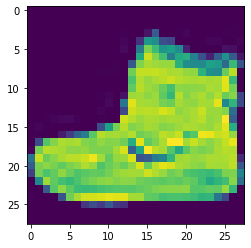

In [51]:
plt.imshow(X_train_full_init[0])

In [52]:
#get all indices which are not Class 8 and 9
import numpy as np
ind_not8or9 = [i for i in range(0,len(y_train_full_init)) if ((y_train_full_init[i] != 8) & (y_train_full_init[i] != 9))]

In [53]:
X_train_full,y_train_full = X_train_full_init[ind_not8or9], y_train_full_init[ind_not8or9]

In [54]:
X_train_full.shape

(48000, 28, 28)

In [55]:
#validation data and train data
#normalize data
X_train,y_train = X_train_full[5000:]/255,y_train_full[5000:]
X_valid,y_valid = X_train_full[:5000]/255,y_train_full[:5000]

In [61]:
#train a 5 layer functional API so we have enough to use for transfer learning with Batch Normalization and Exponenial Linear Unit
#He initializer for Exponential Linear Unit
he_init = keras.initializers.VarianceScaling(scale = 2, mode = 'fan_in',distribution = 'normal')

model_transfer_mnist = keras.models.Sequential()

model_transfer_mnist.add(keras.layers.Flatten(input_shape = [28,28]))

model_transfer_mnist.add(keras.layers.Dense(500, kernel_initializer = he_init, use_bias = False))
model_transfer_mnist.add(keras.layers.BatchNormalization())
model_transfer_mnist.add(keras.layers.ELU())

model_transfer_mnist.add(keras.layers.Dense(400, kernel_initializer = he_init, use_bias = False))
model_transfer_mnist.add(keras.layers.BatchNormalization())
model_transfer_mnist.add(keras.layers.ELU())

model_transfer_mnist.add(keras.layers.Dense(300, kernel_initializer = he_init, use_bias = False))
model_transfer_mnist.add(keras.layers.BatchNormalization())
model_transfer_mnist.add(keras.layers.ELU())

model_transfer_mnist.add(keras.layers.Dense(200, kernel_initializer = he_init, use_bias = False))
model_transfer_mnist.add(keras.layers.BatchNormalization())
model_transfer_mnist.add(keras.layers.ELU())

model_transfer_mnist.add(keras.layers.Dense(100, kernel_initializer = he_init, use_bias = False))
model_transfer_mnist.add(keras.layers.BatchNormalization())
model_transfer_mnist.add(keras.layers.ELU())


model_transfer_mnist.add(keras.layers.Dense(8, activation = "softmax"))

In [62]:
model_transfer_mnist.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)               392000    
_________________________________________________________________
batch_normalization_17 (Batc (None, 500)               2000      
_________________________________________________________________
elu (ELU)                    (None, 500)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 400)               200000    
_________________________________________________________________
batch_normalization_18 (Batc (None, 400)               1600      
_________________________________________________________________
elu_1 (ELU)                  (None, 400)              